# Support.py in Notebook

In [29]:
import numpy as np
import os

import contextlib
import pandas as pd
from datetime import date, datetime

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.objects.petri_net.obj import Marking
from pm4py import conformance
from pm4py.utils import constants

constants.SHOW_PROGRESS_BAR = False

activities = [
    "Invisible 1",
    "Invisible 2",
    "Receiving Request",
    "First Assessment",
    "Fraud Check",
    "Accept",
    "Decline",
    "Create Offer",
    "Contact Customer",
    "Offer Refused",
    "Draw Contract",
    "Send Contract",
]

NR_PLACES = 9

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
    res = []
    with open(path) as fi:
        for line in fi:
            res.append(line.strip().split(", "))

    # reformating the dataset to a pandas dataframe for pm4py compatibility
    df = pd.DataFrame(
        {
            "date": date.today(),
            "case:concept:name": [str(i) for i in range(len(res))],
            "concept:name": res,
        }
    )
    df["date"] = pd.to_datetime(df["date"])
    df = df.explode("concept:name")

    base_timestamp = datetime.now()
    df["time:timestamp"] = base_timestamp + pd.to_timedelta(df.index, unit="h")

    return df


DATASET = load_dataset("dataset_a1.txt")
NR_TRANSITIONS = len(activities)
NAMES_TO_TRANSITION = dict(zip(activities, range(NR_TRANSITIONS)))


def fitness(sol):
    matrix = list_to_array(sol)

    nr_violations = _get_nr_handcrafted_violations(matrix)
    alignment_score = _get_alignment_scores(matrix)
    return (alignment_score - nr_violations,)


def list_to_array(sol):
    return np.array(sol).reshape((NR_TRANSITIONS, 2))


def _get_nr_handcrafted_violations(matrix) -> int:
    nr_arrivals_to_first_place = (matrix[:, 1] == 0).sum()
    nr_departures_from_last_place = (matrix[:, 0] == NR_PLACES - 1).sum()
    nr_self_loops = (matrix[:, 0] == matrix[:, 1]).sum()
    nr_backwards_invisible = (matrix[:2, 0] > matrix[:2, 1] + 2).sum()
    nr_backwards_visible = (matrix[2:, 0] > matrix[2:, 1]).sum()

    return (
        nr_arrivals_to_first_place
        + nr_departures_from_last_place
        + nr_self_loops
        + nr_backwards_invisible
        + nr_backwards_visible
    )


def _get_alignment_scores(matrix) -> float:
    net, initial_marking, final_marking = matrix_to_petrinet(matrix)

    # Needed to redirect the output of the fitness_alignments function, which outputs a lot of text,
    with open(os.devnull, "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            try:
                fa = conformance.fitness_alignments(
                    log=DATASET,
                    petri_net=net,
                    initial_marking=initial_marking,
                    final_marking=final_marking,
                )
            except Exception as e:
                return -1

    alignment_score = fa["average_trace_fitness"]
    return alignment_score


# plot the Petri net
def sol_to_graphviz(sol, output_file="output.pdf"):
    matrix = list_to_array(sol)
    net, _, _ = matrix_to_petrinet(matrix)
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
    gviz = pn_visualizer.apply(net, parameters=parameters)
    pn_visualizer.save(gviz, output_file)


def matrix_to_petrinet(matrix):
    net = PetriNet("PETRINAS")

    places_dict = {}

    for place_nr in range(NR_PLACES):
        place = PetriNet.Place(name=f"p{place_nr}")
        net.places.add(place)
        places_dict[place_nr] = place

        if place_nr == 0:
            first_marking = Marking()
            first_marking[place] = 1

        if place_nr >= NR_PLACES - 1:
            last_marking = Marking()
            last_marking[place] = 1

    for row, activity in enumerate(activities):
        if activity.startswith("Invisible"):
            transition = PetriNet.Transition(name=activity)
        else:
            transition = PetriNet.Transition(name=activity, label=activity)
        net.transitions.add(transition)

        start, end = matrix[row]

        start_place = places_dict[start]
        add_arc_from_to(start_place, transition, net)

        end_place = places_dict[end]
        add_arc_from_to(transition, end_place, net)

    return net, first_marking, last_marking


# Code 

In [30]:
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")
import copy
from tqdm.auto import tqdm

In [31]:
data = load_dataset("dataset_a1.txt")

## Q1

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 50        # Number of Generations
POP_SIZE = 100   # Population size
CXPB = 0.5       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) 
toolbox.register("mate", tools.cxTwoPoint) 

toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB)
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	max	avg     	min	std    
0  	100   	-2 	-9.44618	-18	2.81199
1  	58    	-1.91008	-7.0876 	-12	2.28082
2  	53    	-1.65086	-5.28263	-9 	1.52763
3  	52    	-0.910084	-4.13814	-8 	1.44725
4  	62    	0.0899158	-3.04139	-7 	1.34297
5  	62    	0.0899158	-2.27554	-5.67392	1.04935
6  	62    	0.296757 	-1.69302	-5      	1.07831
7  	64    	0.346757 	-1.09706	-3.69362	0.881088
8  	55    	0.346757 	-0.555666	-4      	0.799826
9  	56    	0.369587 	-0.131061	-2      	0.625611
10 	60    	0.369587 	0.150541 	-1.91008	0.400645
11 	71    	0.369587 	0.0953833	-3      	0.669121
12 	54    	0.369587 	0.173558 	-2.68041	0.5001  
13 	59    	0.369587 	0.265018 	-3      	0.427854
14 	72    	0.369587 	0.214465 	-2.63041	0.517835
15 	68    	0.369587 	0.296926 	-2.60829	0.378945
16 	63    	0.369587 	0.229587 	-1.63041	0.423144
17 	70    	0.369587 	0.320575 	-0.630413	0.211646
18 	63    	0.369587 	0.309289 	-1.63041 	0.274991
19 	66    	0.369587 	0.157903 	-4.77526 	0.721693
20 	58    	0.369587 	0.197286

In [ ]:
best_ind = hof[0]
# print("\nBest Individual:")
# print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

# best_matrix = list_to_array(best_ind)
# print("\nBest Matrix:")
# print(best_matrix)


Best Individual:
[7, 5, 5, 3, 0, 4, 4, 7, 5, 7, 5, 7, 7, 8, 3, 5, 5, 7, 3, 8, 5, 7, 7, 8]
Fitness: 0.958988095238095


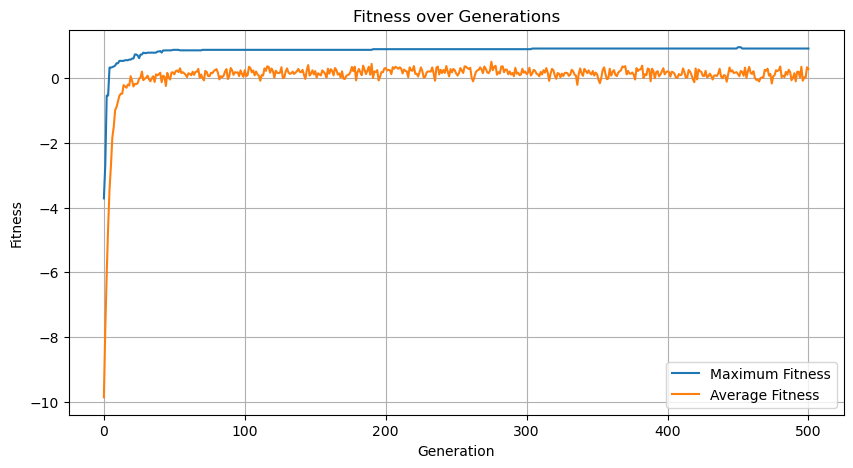

In [58]:
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

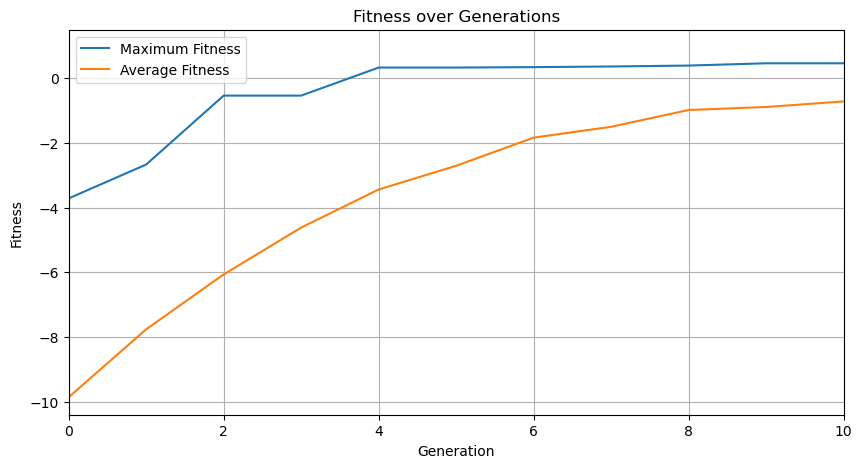

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.xlim(0, 10)
plt.grid(True)
plt.show()

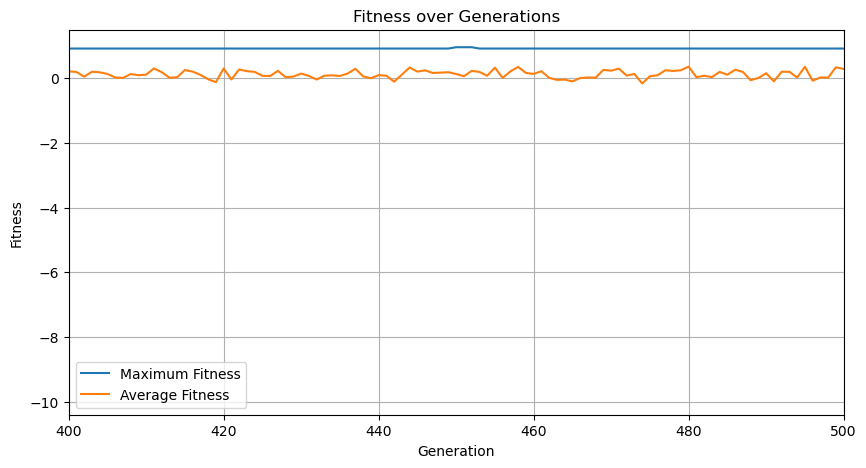

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.xlim(400, 500)
plt.grid(True)
plt.show()

In [35]:
# Visualize the best Petri net found
output_filename = "viz_petri_nets/best_petri_net.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to viz_petri_nets/best_petri_net.pdf


# Q2

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox() # Create new empty toolbox

NGEN = 50        # Number of Generations
NUM_RUNS = 10    # Number of runs for boxplots  
POP_SIZE = 100   # Population size
CXPB = 0.5       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)

crossover_list = [tools.cxTwoPoint, tools.cxOrdered]
mutation_list = [tools.mutUniformInt, tools.mutShuffleIndexes]
selection_list = [tools.selTournament, tools.selRoulette]

combinations = list(itertools.product(crossover_list, mutation_list, selection_list))

In [ ]:
def register_specified_variant(toolbox, Crossover, Mutation, Selection):
    toolbox.register("mate", Crossover) 
    if Mutation is tools.mutUniformInt:
        toolbox.register(
            "mutate",
            tools.mutUniformInt,
            low=0,               
            up=NR_PLACES - 1,    
            indpb=INDPB          
        )
    else:
        toolbox.register("mutate", Mutation, indpb=INDPB)

    if Selection == tools.selTournament:
        toolbox.register("select", Selection, tournsize=TOURNSIZE) 
    else:
        toolbox.register("select", Selection)
    return toolbox

def run_genetic_algorithm_q2(toolbox, num_runs=NUM_RUNS):
    max_fitnesses_all_runs = []

    for run in tqdm(range(num_runs), desc="GA Runs", leave=True):

        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)

        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                           stats=stats, halloffame=hof, verbose=False)
        
        max_fitness = logbook.select("max")
        max_fitnesses_all_runs.append(max_fitness)

    max_fitnesses_all_runs = np.array(max_fitnesses_all_runs).T

    return max_fitnesses_all_runs

def plot_boxplot(max_fitnesses_all_runs, title):
    final_max_fitnesses = max_fitnesses_all_runs[-1, :]

    plt.figure(figsize=(8, 6))
    plt.boxplot(final_max_fitnesses, patch_artist=True) 
    plt.xlabel("Operator Combination")
    plt.ylabel("Final Maximum Fitness")
    plt.title(title)
    plt.xticks([1], ['']) 
    plt.grid(True, axis='y') 
    plt.show()

def plot_ABF(max_fitnesses_all_runs, title):
    abf = np.mean(max_fitnesses_all_runs, axis=1)
    generations = range(len(abf))

    plt.figure(figsize=(10, 5))
    plt.plot(generations, abf, label="Average Best Fitness (ABF)")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
results = {}

for i, comb in enumerate(tqdm(combinations, desc="Evaluating combinations")):
    tbx = base.Toolbox()
    tbx.__dict__.update(copy.deepcopy(toolbox.__dict__))

    tbx = register_specified_variant(tbx, comb[0], comb[1], comb[2])

    print(f"Running combination {i+1}/{len(combinations)}: {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}")
    max_fitnesses_all_runs = run_genetic_algorithm_q2(tbx)
    results[i] = max_fitnesses_all_runs

Evaluating combinations:   0%|          | 0/8 [00:00<?, ?it/s]

Running combination 1/8: cxTwoPoint, mutUniformInt, selTournament


Evaluating combinations:  12%|█▎        | 1/8 [08:33<59:51, 513.03s/it]

Running combination 2/8: cxTwoPoint, mutUniformInt, selRoulette


Evaluating combinations:  25%|██▌       | 2/8 [16:14<48:14, 482.50s/it]

Running combination 3/8: cxTwoPoint, mutShuffleIndexes, selTournament


Evaluating combinations:  38%|███▊      | 3/8 [39:38<1:15:16, 903.32s/it]

Running combination 4/8: cxTwoPoint, mutShuffleIndexes, selRoulette


Evaluating combinations:  50%|█████     | 4/8 [1:21:30<1:42:33, 1538.36s/it]

Running combination 5/8: cxOrdered, mutUniformInt, selTournament


Evaluating combinations:  62%|██████▎   | 5/8 [1:47:32<1:17:21, 1547.02s/it]

Running combination 6/8: cxOrdered, mutUniformInt, selRoulette


Evaluating combinations:  75%|███████▌  | 6/8 [1:54:52<39:01, 1170.67s/it]  

Running combination 7/8: cxOrdered, mutShuffleIndexes, selTournament


Evaluating combinations:  88%|████████▊ | 7/8 [2:02:36<15:39, 939.62s/it] 

Running combination 8/8: cxOrdered, mutShuffleIndexes, selRoulette


Evaluating combinations: 100%|██████████| 8/8 [2:09:22<00:00, 970.31s/it]


In [ ]:
records = []
for i, (cx_op, mut_op, sel_op) in enumerate(combinations):
    arr = results[i]         
    abf_final = arr[-1, :].mean()   
    records.append({
        'Crossover': cx_op.__name__,
        'Mutation' : mut_op.__name__,
        'Selection': sel_op.__name__,
        'ABF'      : round(abf_final, 4)
    })

df_abf = pd.DataFrame(records,
                      columns=['Crossover','Mutation','Selection','ABF'])
print(df_abf)


    Crossover           Mutation      Selection     ABF
0  cxTwoPoint      mutUniformInt  selTournament  0.6456
1  cxTwoPoint      mutUniformInt    selRoulette  0.5394
2  cxTwoPoint  mutShuffleIndexes  selTournament  0.5983
3  cxTwoPoint  mutShuffleIndexes    selRoulette  0.5370
4   cxOrdered      mutUniformInt  selTournament  0.6765
5   cxOrdered      mutUniformInt    selRoulette  0.5687
6   cxOrdered  mutShuffleIndexes  selTournament  0.6417
7   cxOrdered  mutShuffleIndexes    selRoulette  0.5727


In [13]:
def plot_boxplot(results, combinations, title):
    all_final_max_fitnesses = []
    labels = []
    for i, comb in enumerate(combinations):
        max_fitnesses_all_runs = results[i]
        final_max_fitnesses = max_fitnesses_all_runs[-1, :]
        all_final_max_fitnesses.append(final_max_fitnesses)
        labels.append(f"{comb[0].__name__}\n{comb[1].__name__}\n{comb[2].__name__}") 

    plt.figure(figsize=(15, 8)) 
    plt.boxplot(all_final_max_fitnesses, labels=labels, patch_artist=True)
    plt.xlabel("Operator Combination (Crossover, Mutation, Selection)")
    plt.ylabel("Final Maximum Fitness")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout() 
    plt.show()

def plot_ABF(results, combinations, title):
    plt.figure(figsize=(12, 6)) 
    generations = None 

    for i, comb in enumerate(combinations):
        max_fitnesses_all_runs = results[i]
        abf = np.mean(max_fitnesses_all_runs, axis=1)
        if generations is None:
             generations = range(len(abf)) 
        label = f"{comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
        plt.plot(generations, abf, label=label)

    plt.xlabel("Generation")
    plt.ylabel("Average Best Fitness (ABF)")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
    plt.grid(True)
    plt.tight_layout() 
    plt.show()

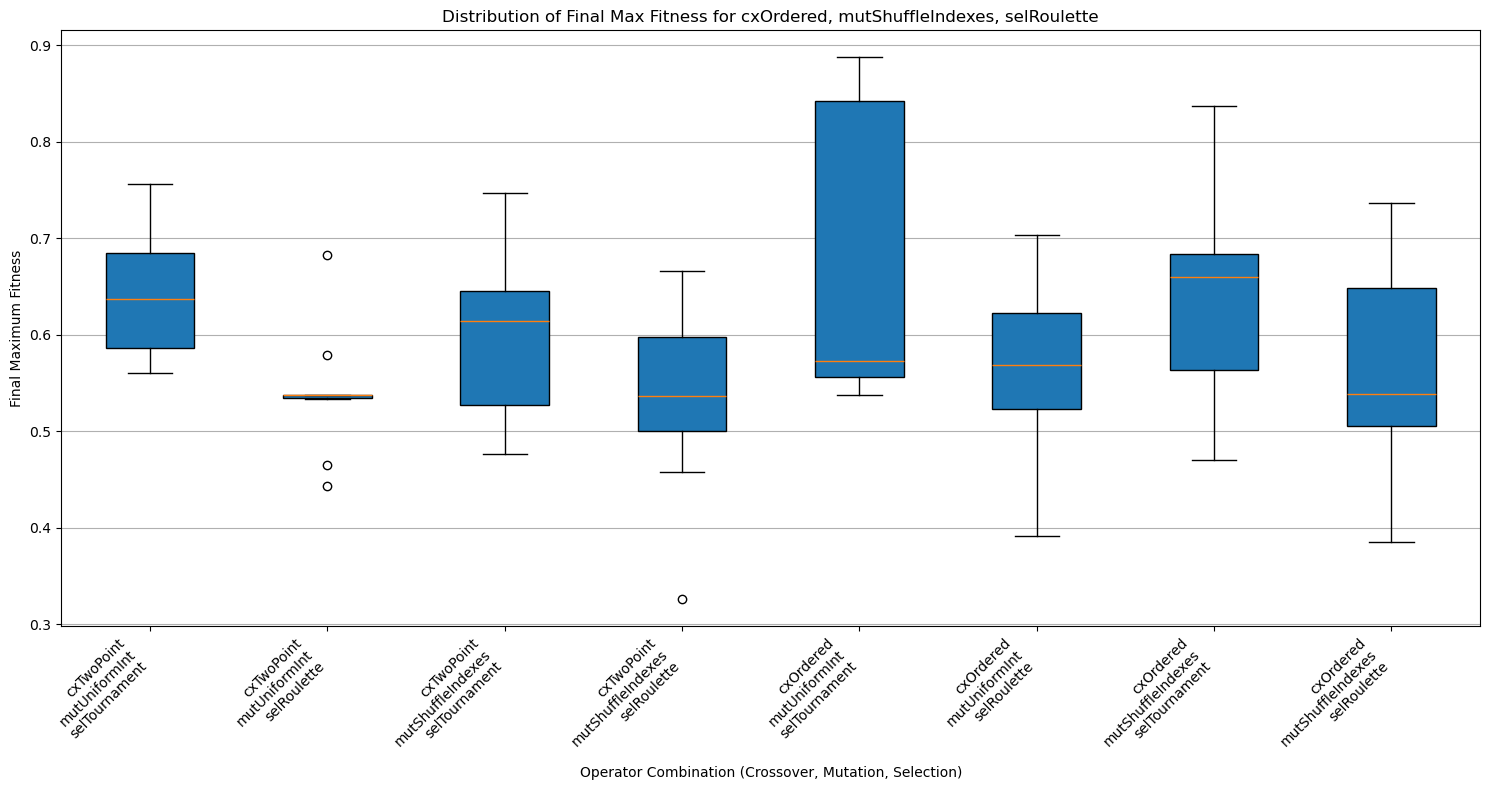

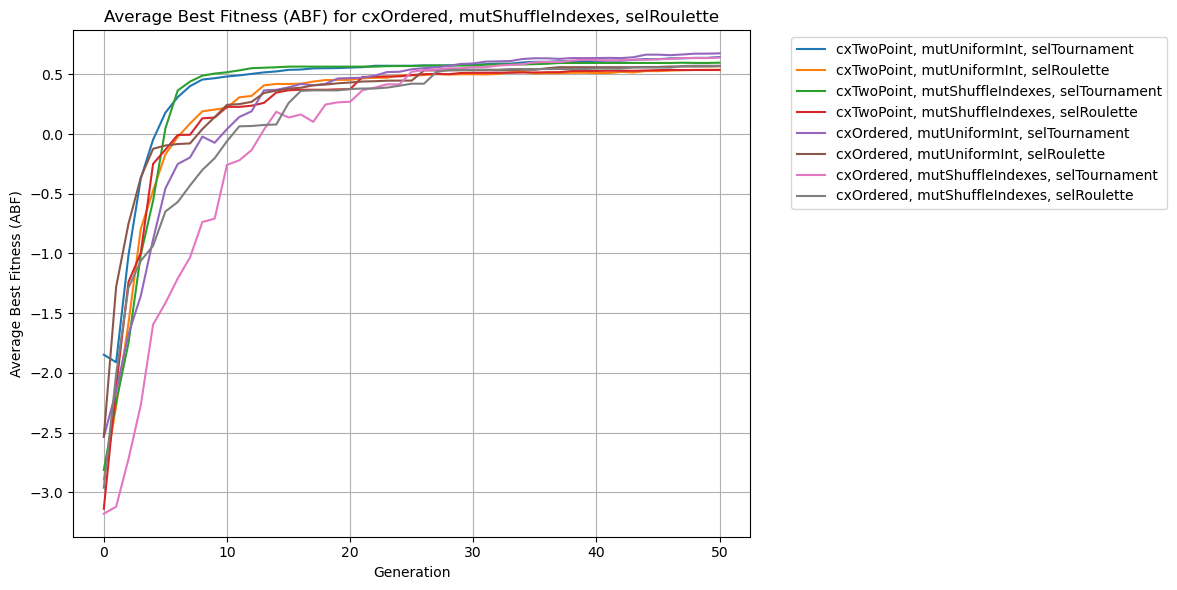

In [14]:
title = f"Distribution of Final Max Fitness for {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
plot_boxplot(results, combinations, title)
title = f"Average Best Fitness (ABF) for {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
plot_ABF(results, combinations, title)

In [15]:
del creator.FitnessMax
del creator.Individual

# Q3

In [16]:
NUM_RUNS = 10
NGEN = 50
POP_SIZE = 100

In [17]:
def run_genetic_algorithm(toolbox, cxpb, mutpb, num_runs=NUM_RUNS):
    """
    Runs the GA num_runs times with the given crossover/mutation probabilities.
    Returns an array shape (n_generations, num_runs) of max fitness per gen/run.
    """
    max_fitnesses_all_runs = []

    for run in tqdm(range(num_runs), desc=f"GA Runs (cxpb={cxpb}, mutpb={mutpb})"):
        
        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)

        pop, logbook = algorithms.eaSimple(
            pop, toolbox,
            cxpb=cxpb,
            mutpb=mutpb,
            ngen=NGEN,
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        # collect the max fitness at each generation
        max_fitnesses_all_runs.append(logbook.select("max"))

    # shape into (generations, runs)
    return np.array(max_fitnesses_all_runs).T

crossover_prob_list = [0.2, 0.4, 0.6, 0.8]
mutation_prob_list  = [0.2, 0.4, 0.6, 0.8]
combinations_q3 = list(itertools.product(crossover_prob_list, mutation_prob_list))

best_crossover = tools.cxTwoPoint
best_mutation  = tools.mutUniformInt
best_selection = tools.selTournament

tbx = base.Toolbox()
tbx.__dict__.update(copy.deepcopy(toolbox.__dict__))
tbx = register_specified_variant(tbx,best_crossover,best_mutation, best_selection)
results_q3 = {}
for i, (cxpb, mutpb) in enumerate(
        tqdm(combinations_q3, desc="Evaluating prob combinations")):

    max_fit = run_genetic_algorithm(tbx, cxpb, mutpb)
    results_q3[(cxpb, mutpb)] = max_fit

Evaluating prob combinations: 100%|██████████| 16/16 [4:20:59<00:00, 978.71s/it] 


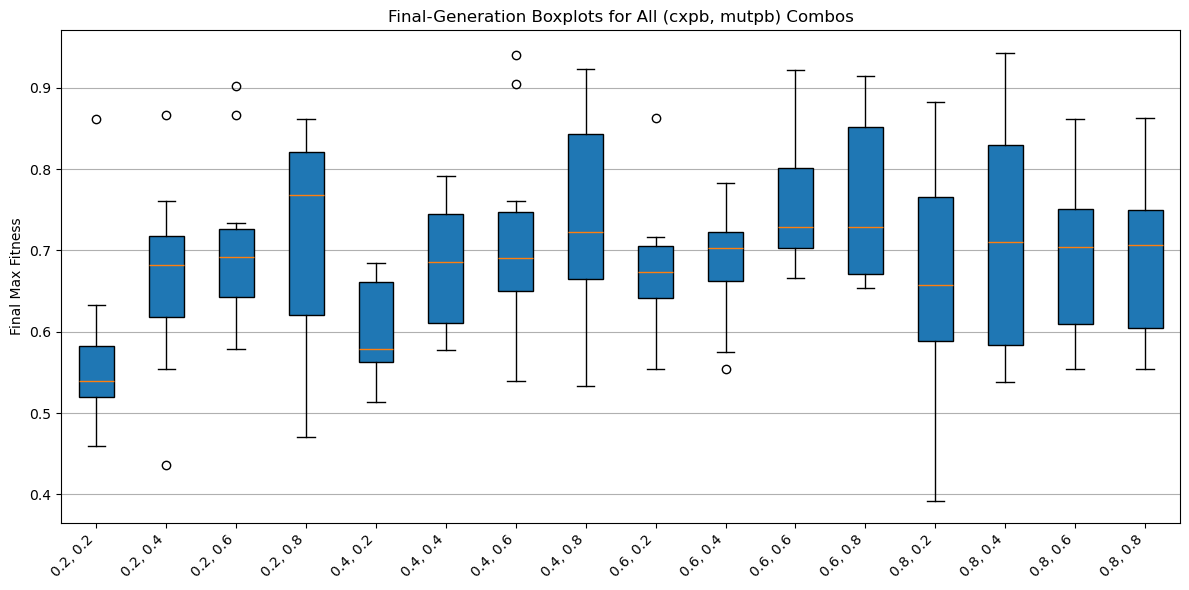

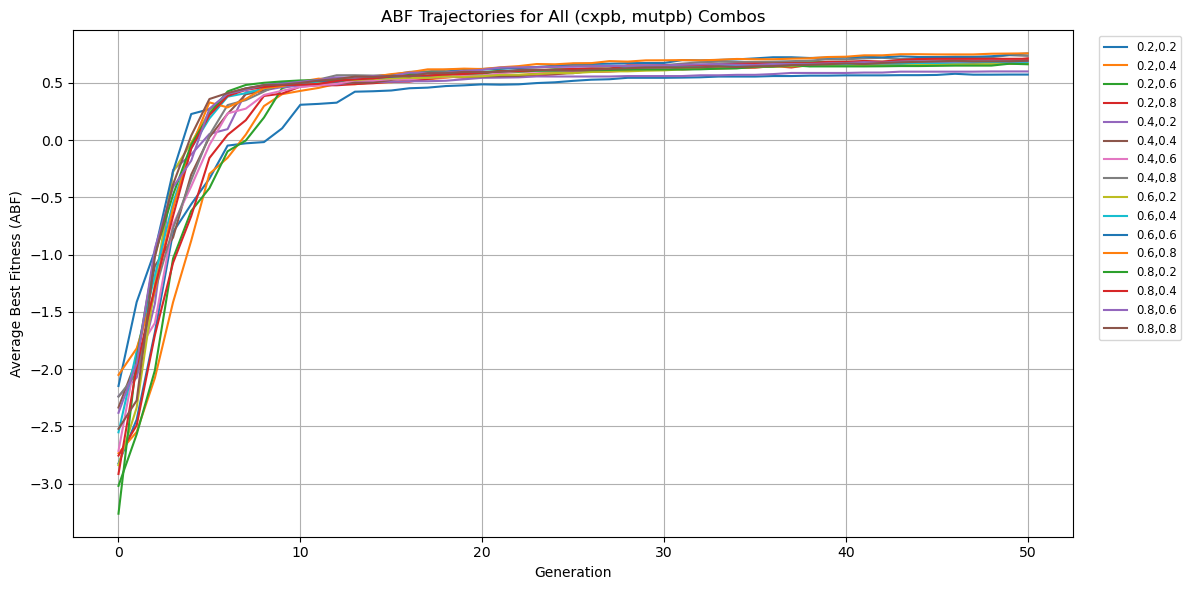

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

labels = []
data_to_plot = []
for (cxpb, mutpb), arr in results_q3.items():
    # arr shape is (n_gens, n_runs); take the last row = final-gen fitnesses
    final_gen = arr[-1, :]
    data_to_plot.append(final_gen)
    labels.append(f"{cxpb:.1f}, {mutpb:.1f}")

ax.boxplot(data_to_plot, patch_artist=True)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel("Final Max Fitness")
ax.set_title("Final‐Generation Boxplots for All (cxpb, mutpb) Combos")
ax.grid(axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

for (cxpb, mutpb), arr in results_q3.items():
    # compute ABF = mean over runs at each generation
    abf = arr.mean(axis=1)
    gens = range(len(abf))
    ax.plot(gens, abf, label=f"{cxpb:.1f},{mutpb:.1f}")

ax.set_xlabel("Generation")
ax.set_ylabel("Average Best Fitness (ABF)")
ax.set_title("ABF Trajectories for All (cxpb, mutpb) Combos")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
ax.grid()
plt.tight_layout()
plt.show()


In [19]:
records = []
for (cxpb, mutpb), arr in results_q3.items():
    # take the last generation (arr[-1,:]) and average over runs
    avg_best = arr[-1, :].mean()
    records.append({
        'mutation': mutpb,
        'crossover': cxpb,
        'avg_best_fitness': avg_best
    })

df = pd.DataFrame(records)
table = df.pivot(index='mutation',
                 columns='crossover',
                 values='avg_best_fitness')

table.index.name = 'mutation prob'
table.columns.name = 'crossover prob'
print(table.round(4))

crossover prob     0.2     0.4     0.6     0.8
mutation prob                                 
0.2             0.5728  0.6002  0.6739  0.6627
0.4             0.6683  0.6781  0.6831  0.7104
0.6             0.7097  0.7086  0.7568  0.6902
0.8             0.7140  0.7358  0.7580  0.6933


# Q4

In [ ]:
def checkSelfLoops():
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for idx, child in enumerate(offspring):
                matrix = list_to_array(child)
                for i in range(matrix.shape[0]):
                    if matrix[i][0] == matrix[i][1]:
                        if matrix[i][1] == NR_PLACES - 1:
                            matrix[i][0] -= 1
                        else:
                            matrix[i][1] += 1
                offspring[idx][:] = matrix.flatten().tolist()
            return offspring
        return wrapper
    return decorator

def checkBackwardsVisibleLoops():
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for idx, child in enumerate(offspring):
                matrix = list_to_array(child)
                for i in range(matrix.shape[0]):
                    if matrix[i][0] > matrix[i][1]:
                        matrix[i][0], matrix[i][1] = matrix[i][1], matrix[i][0]
                offspring[idx][:] = matrix.flatten().tolist()
            return offspring
        return wrapper
    return decorator

In [47]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 500        # Number of Generations
# Just took standard values for hyperparameters
POP_SIZE = 100   # Population size
CXPB = 0.6       # Crossover Probability
MUTPB = 0.8      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) # Uses fitness function from support to evaluate fitness
toolbox.register("mate", tools.cxTwoPoint) 
# toolbox.register("mutate", tools.mutFlipBit, indpb=INDPB) # indpb is the probability of flipping each bit in the individual
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB) # low and up are the bounds for the mutation, indpb is the probability of mutation for each gene
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)  # tournsize is the number of individuals to select for the tournament, fittest is selected for next gen

toolbox.decorate("mate", checkSelfLoops()) # Decorate the mate function to check for self-loops
toolbox.decorate("mate", checkBackwardsVisibleLoops()) # Decorate the mate function to check for backwards visible loops
toolbox.decorate("mutate", checkSelfLoops())
toolbox.decorate("mutate", checkBackwardsVisibleLoops())

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)



gen	nevals	max     	avg     	min	std    
0  	100   	-1.66845	-8.85116	-16	2.88671
1  	88    	0.538094	-0.858501	-9 	2.29672
2  	94    	0.538094	0.141076 	-1 	0.416798
3  	95    	0.538094	0.285751 	-1 	0.307592
4  	95    	0.540972	0.324559 	-1 	0.32119 
5  	92    	0.560846	0.422232 	-1 	0.174461
6  	88    	0.558763	0.433379 	-1 	0.186485
7  	91    	0.538094	0.455094 	-1 	0.263711
8  	94    	0.538094	0.469441 	-1 	0.271168
9  	95    	0.558763	0.461311 	-1 	0.267182
10 	86    	0.558763	0.497614 	-1 	0.21755 
11 	92    	0.558763	0.424362 	-1 	0.341063
12 	89    	0.558763	0.403369 	-1 	0.394655
13 	96    	0.558763	0.399641 	-1 	0.39488 
14 	92    	0.558763	0.405208 	-1 	0.39048 
15 	93    	0.59851 	0.472114 	-1 	0.263545
16 	95    	0.578636	0.452277 	-1 	0.302425
17 	93    	0.599305	0.357303 	-1 	0.457543
18 	89    	0.599305	0.442207 	-1 	0.335788
19 	93    	0.579431	0.426843 	-1 	0.366189
20 	94    	0.579431	0.445468 	-1 	0.337265
21 	93    	0.579431	0.421597 	-1 	0.392703
22 	91    	0.579

### Results Q4 for Q5 (using Tool Decorators)

In [48]:
best_ind = hof[0]
print("\nBest Individual:")
# print(best_ind)
best_matrix = list_to_array(best_ind) 
print(best_matrix)
print(f"Fitness: {best_ind.fitness.values[0]}")

# best_matrix = list_to_array(best_ind) 
# print("\nBest Matrix:")
# print(best_matrix)


Best Individual:
[[7 8]
 [5 7]
 [0 4]
 [4 5]
 [5 7]
 [5 6]
 [7 8]
 [3 5]
 [6 7]
 [7 8]
 [3 7]
 [7 8]]
Fitness: 0.7989213564213568


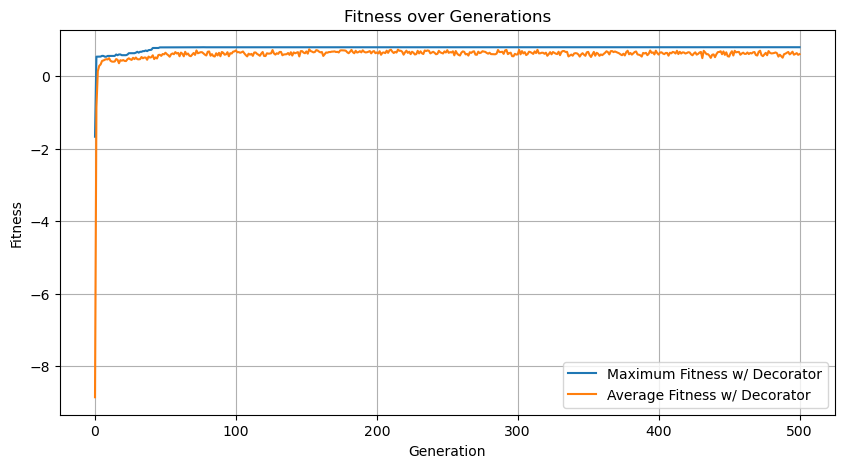

In [49]:
gen_q4 = logbook.select("gen")
max_fitness_q4 = logbook.select("max")
avg_fitness_q4 = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen_q4, max_fitness_q4, label="Maximum Fitness w/ Decorator")
plt.plot(gen_q4, avg_fitness_q4, label="Average Fitness w/ Decorator") 
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Visualize the best Petri net found
output_filename = "viz_petri_nets/best_petri_net_decorator.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to viz_petri_nets/best_petri_net_decorator.pdf


# Q5

### Results Q4 for Q5 (without Tool Decorators / equal to Q1 with optimal parameters from Q2/Q3)

In [51]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 500        # Number of Generations
# Just took standard values for hyperparameters
POP_SIZE = 100   # Population size
CXPB = 0.6       # Crossover Probability
MUTPB = 0.8      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) # Uses fitness function from support to evaluate fitness
toolbox.register("mate", tools.cxTwoPoint) 
# toolbox.register("mutate", tools.mutFlipBit, indpb=INDPB) # indpb is the probability of flipping each bit in the individual
# uniform integer mutation: each gene is reset to U(low,up) with probability indpb
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB) # low and up are the bounds for the mutation, indpb is the probability of mutation for each gene
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)  # tournsize is the number of individuals to select for the tournament, fittest is selected for next gen

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	max     	avg     	min	std    
0  	100   	-3.71439	-9.86474	-16	2.64046
1  	87    	-2.66653	-7.76381	-13	2.19452
2  	91    	-0.534152	-6.06642	-11	1.79554
3  	88    	-0.534152	-4.61642	-9 	1.76653
4  	89    	0.333465 	-3.43832	-12	1.89996
5  	91    	0.333465 	-2.70492	-7.59523	1.63066
6  	91    	0.346757 	-1.83381	-8      	1.34899
7  	96    	0.366715 	-1.49921	-6      	1.19411
8  	94    	0.395237 	-0.979255	-4.65324	1.02617
9  	91    	0.465848 	-0.88671 	-6      	1.1763 
10 	90    	0.465848 	-0.713931	-5      	1.0943 
11 	94    	0.5397   	-0.541705	-5      	0.928908
12 	92    	0.5397   	-0.475078	-4      	1.0668  
13 	86    	0.5397   	-0.477178	-4.60829	1.1864  
14 	92    	0.5397   	-0.210513	-5      	1.03376 
15 	93    	0.560889 	-0.250371	-3.65324	0.968904
16 	93    	0.560889 	-0.289339	-4.37942	1.03143 
17 	94    	0.560889 	-0.192575	-4      	1.02805 
18 	90    	0.580397 	-0.222008	-4      	1.12041 
19 	94    	0.578636 	0.0667668	-3      	0.833439
20 	94    	0.612593 	-0.0

In [52]:
best_ind = hof[0]
print("\nBest Individual:")
print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

best_matrix = list_to_array(best_ind)
# print("\nBest Matrix:")
# print(best_matrix)


Best Individual:
[2, 8, 3, 2, 0, 1, 1, 2, 2, 3, 2, 3, 2, 3, 3, 6, 6, 7, 7, 8, 7, 8, 0, 5]
Fitness: 0.9626645021645024


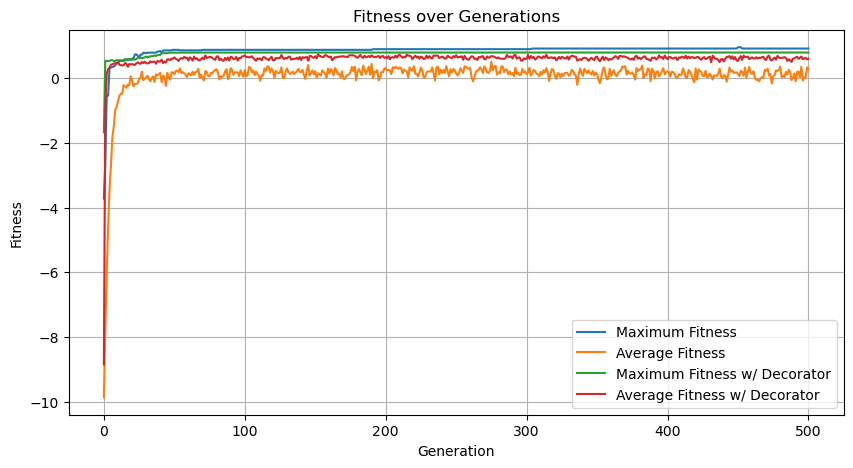

In [53]:
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.plot(gen_q4, max_fitness_q4, label="Maximum Fitness w/ Decorator")
plt.plot(gen_q4, avg_fitness_q4, label="Average Fitness w/ Decorator") 
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Visualize the best Petri net found
output_filename = "viz_petri_nets/best_petri_net_Q1_optimal_param.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to viz_petri_nets/best_petri_net_Q1_optimal_param.pdf
